# ARIMA - Auto Regressive Integrated Moving Average


### In an ARIMA model there are 3 parameters, namely p, q and d that help model major aspects of a time series: seasonality, trend and noise. If our model has a seasonal component, we use Seasonal ARIMA with parameters, P, Q and D related to seasonal components of the model.

* #### p is the order of AR Term
* #### d is the number of differencing required to make the TS stationary
* #### q is the MA Term

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import warnings 
warnings.filterwarnings('ignore')

import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error

In [143]:
data = yf.Ticker("MSFT")
df = data.history(period="max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062427,0.064042,0.062427,0.063503,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063504,0.064042,0.061350,0.061889,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061889,0.062427,0.060274,0.060812,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,373.679993,375.179993,372.709991,374.579987,17091100,0.0,0.0
2023-12-26 00:00:00-05:00,375.000000,376.940002,373.500000,374.660004,12673100,0.0,0.0
2023-12-27 00:00:00-05:00,373.690002,375.059998,372.809998,374.070007,14905400,0.0,0.0


In [144]:
df.reset_index(inplace=True)

In [145]:
df['Date'] = df['Date'].apply(str).str[0:10]

In [146]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9522   2023-12-22
9523   2023-12-26
9524   2023-12-27
9525   2023-12-28
9526   2023-12-29
Name: Date, Length: 9527, dtype: datetime64[ns]

In [147]:
df.set_index('Date', inplace=True)

In [148]:
df = df[['Close']]

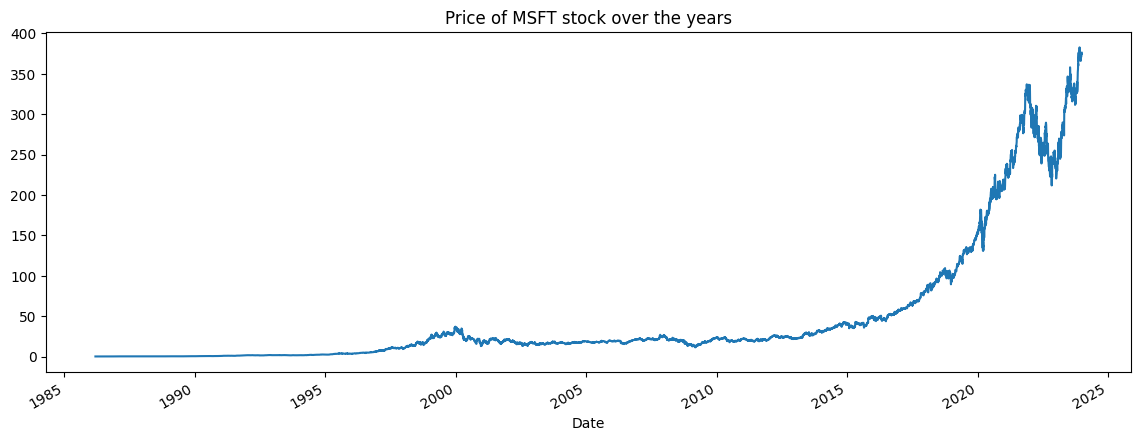

In [149]:
plt.figure(figsize=(14,5))
df['Close'].plot()
plt.title('Price of MSFT stock over the years')
plt.show()

### Downsizing the dataset

In [150]:
df = df[(df.index > '2019') & (df.index < '2023-12')]

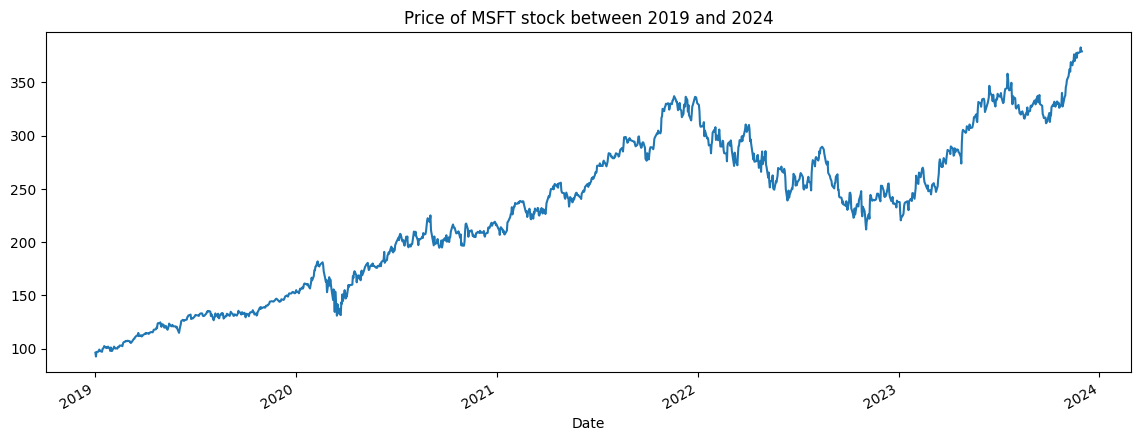

In [151]:
plt.figure(figsize=(14,5))
df['Close'].plot()
plt.title('Price of MSFT stock between 2019 and 2024')
plt.show()

### Time Series Decomposition

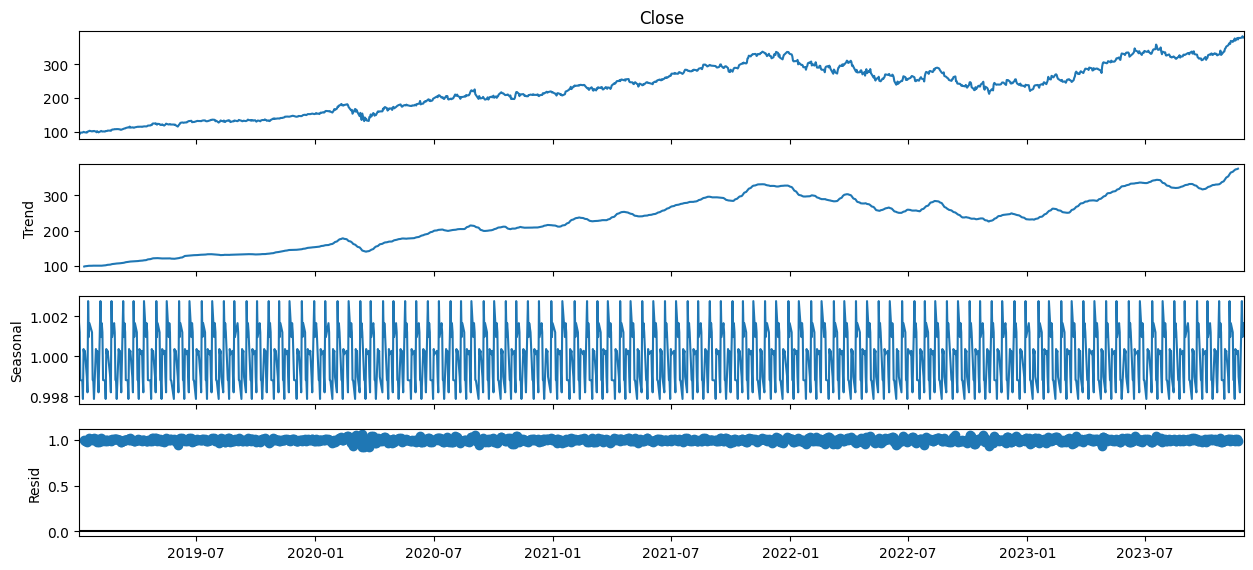

In [152]:
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=12)

fig = decomposition.plot()
fig.set_size_inches(14,6)
plt.show()

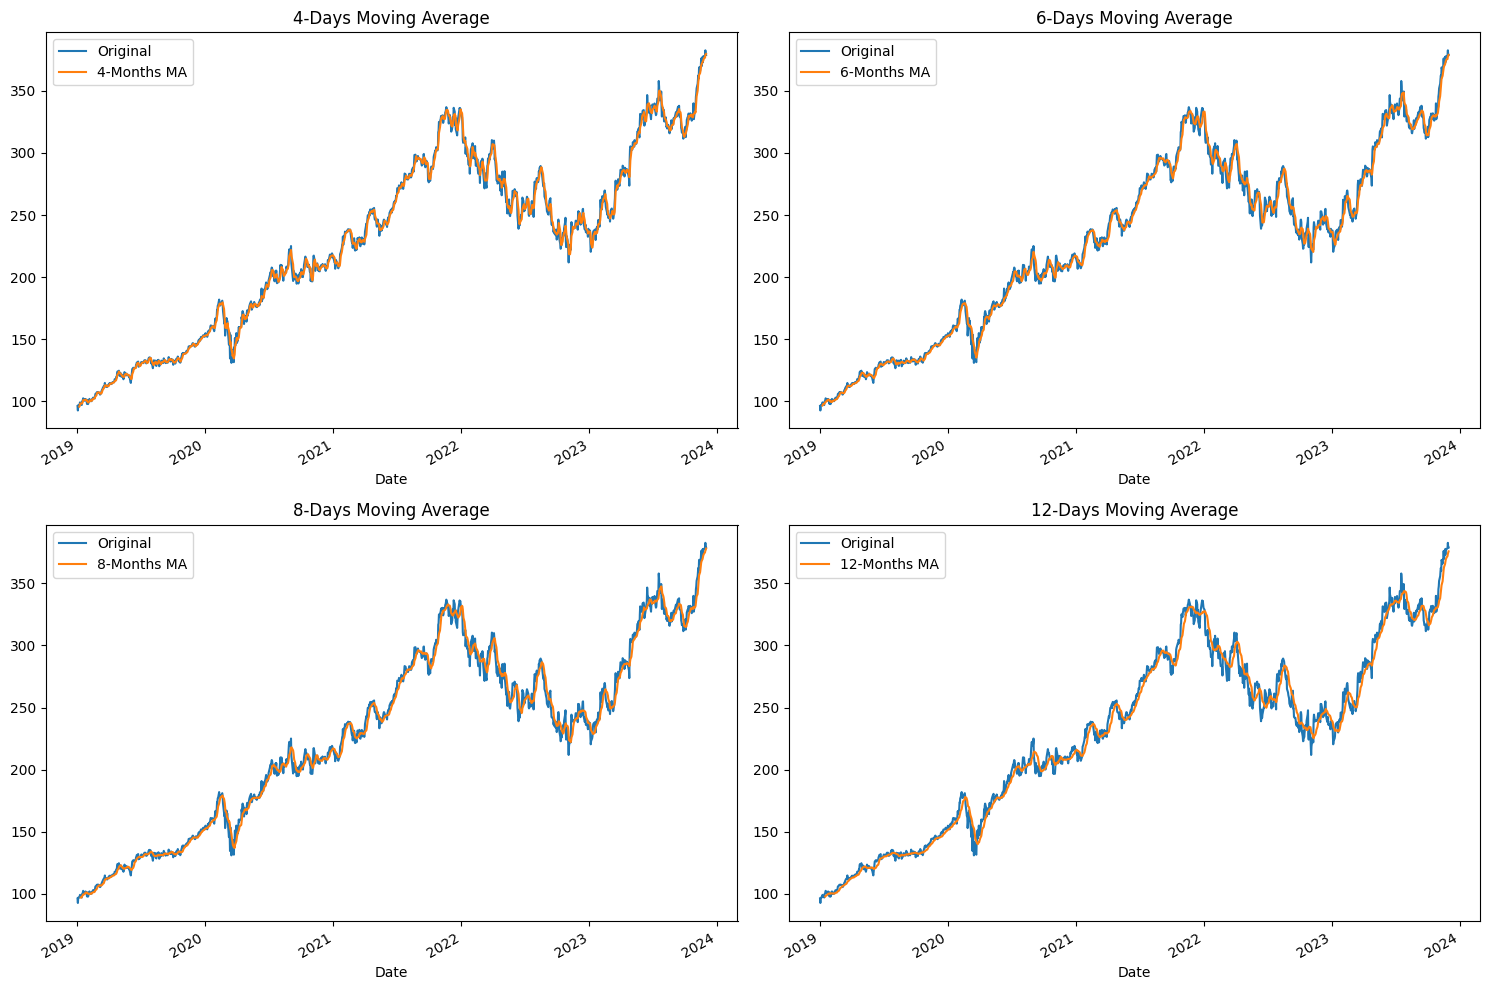

In [153]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
df['Close'].plot(ax=ax[0][0], label='Original')
df['Close'].rolling(4).mean().plot(ax=ax[0][0], label='4-Months MA')
ax[0][0].set_title('4-Days Moving Average')
ax[0][0].legend(loc='best')

df['Close'].plot(ax=ax[0][1], label='Original')
df['Close'].rolling(6).mean().plot(ax=ax[0][1], label='6-Months MA')
ax[0][1].set_title('6-Days Moving Average')
ax[0][1].legend(loc='best')

df['Close'].plot(ax=ax[1][0], label='Original')
df['Close'].rolling(8).mean().plot(ax=ax[1][0], label='8-Months MA')
ax[1][0].set_title('8-Days Moving Average')
ax[1][0].legend(loc='best')

df['Close'].plot(ax=ax[1][1], label='Original')
df['Close'].rolling(12).mean().plot(ax=ax[1][1], label='12-Months MA')
ax[1][1].set_title('12-Days Moving Average')
ax[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

### Augmented Dickey-Fuller Test - Let's run the Augmented Dicky Fuller Test on the timeseries and verify $H_0$ that the TS is non-stationary.

##### The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an essential concept in time series analysis, as many time series models and algorithms assume that the underlying data is stationary, which means that statistical properties such as the mean and variance do not change over time.

##### The ADF test is an extension of the Dickey-Fuller test and is often used to test for the presence of a unit root in a time series. A unit root implies non-stationarity, meaning that the time series has some form of trend and is not constant over time.

##### The null hypothesis of the ADF test is that a unit root is present in the time series, indicating that the data is non-stationary. The alternative hypothesis is that there is no unit root, implying that the time series is stationary.

##### If the p-value is small enough, you can reject the null hypothesis and conclude that the time series is stationary. If the ADF statistic is more negative than the critical values, it further supports the stationarity conclusion.

In [154]:
from statsmodels.tsa.stattools import adfuller

In [155]:
dftest = adfuller(df['Close'])
print('ADF test statistic is %3.3f' %dftest[0])
print('ADF test p-value is %1.4f' %dftest[1])

ADF test statistic is -0.689
ADF test p-value is 0.8495


##### We can't reject $H_0$, hence the time series is not stationary.
##### Our Preliminary Job is to make this TS stationary.

### Autocorrelation Function (ACF)

##### Autocorrelation refers to the correlation of a time series with its own past values. In simpler terms, it assesses how well the current value of a variable is related to its past values.

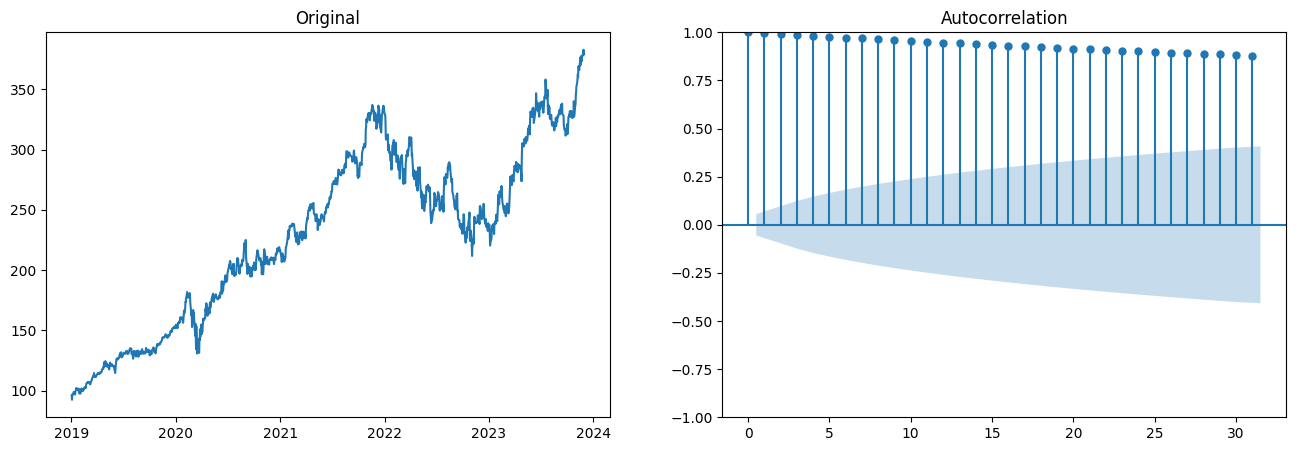

In [156]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(df['Close'])
ax[0].set_title('Original')
plot_acf(df['Close'], ax=ax[1])
plt.show()

In [157]:
df['Close'].diff()  # Difference between the element and element in previous record.

Date
2019-01-02         NaN
2019-01-03   -3.532494
2019-01-04    4.301651
2019-01-07    0.123474
2019-01-08    0.702705
                ...   
2023-11-24   -0.420013
2023-11-27    1.179993
2023-11-28    4.090027
2023-11-29   -3.850006
2023-11-30    0.059998
Name: Close, Length: 1238, dtype: float64

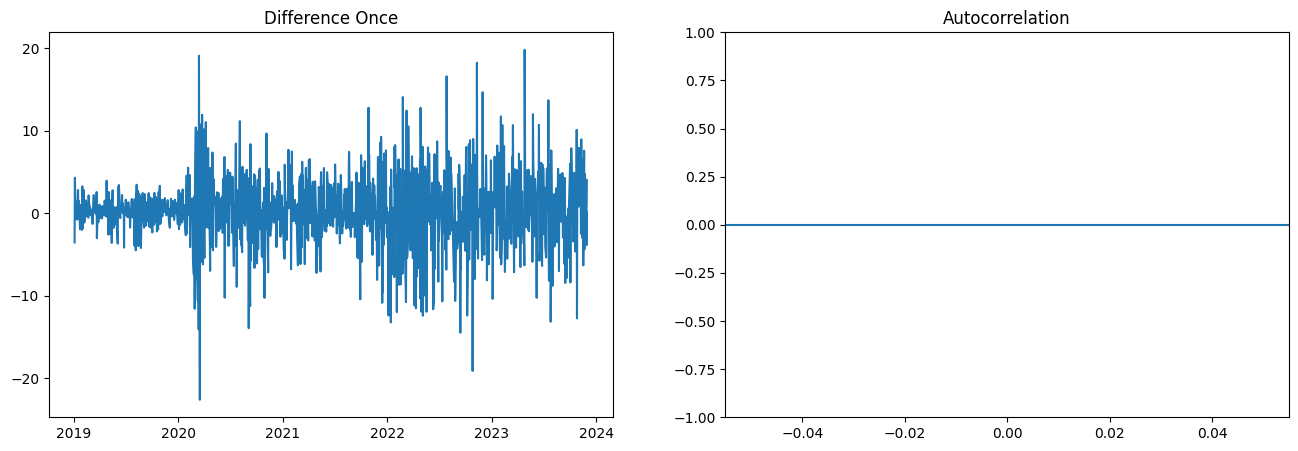

In [158]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(df['Close'].diff())
ax[0].set_title('Difference Once')
plot_acf(df['Close'].diff(), ax=ax[1])
plt.show()

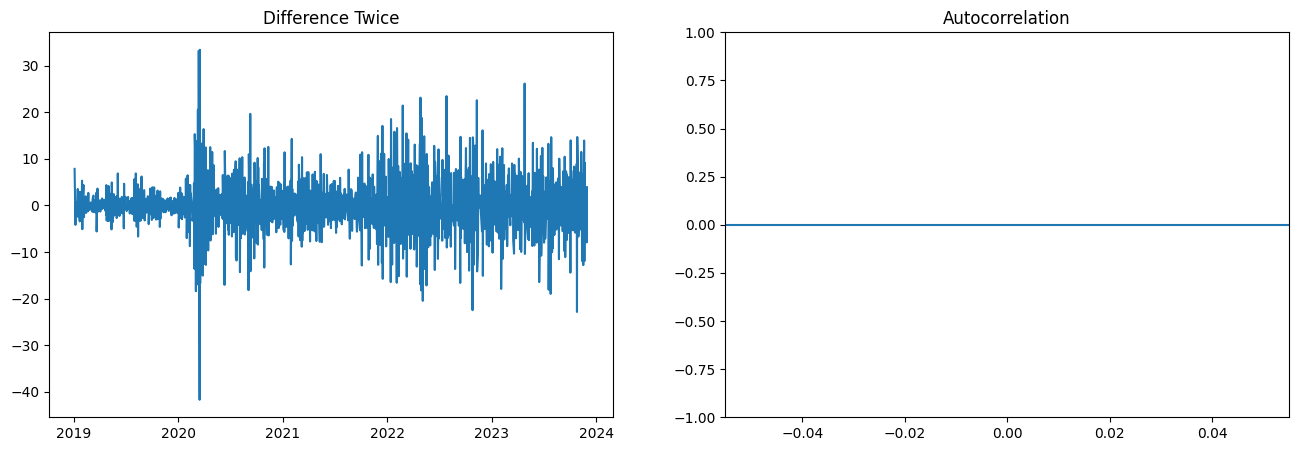

In [159]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(df['Close'].diff().diff())
ax[0].set_title('Difference Twice')
plot_acf(df['Close'].diff().diff(), ax=ax[1])
plt.show()

##### Observe that after 1 difference, the correlation between TS's has come down drastically. So, the parameter 'd' in ARIMA would be 1 i.e., after only 1 difference, we were able to achieve a sort-of same mean throughout the TS.

##### Also, we can use pmdarima package to get the number of differencing

In [160]:
from pmdarima.arima.utils import ndiffs

ndiffs(df['Close'], test='adf')

1

---

### p

#### p is the order of Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.
#### We can find the required number of AR terms by looking at Partial Autocorrelation Plot.

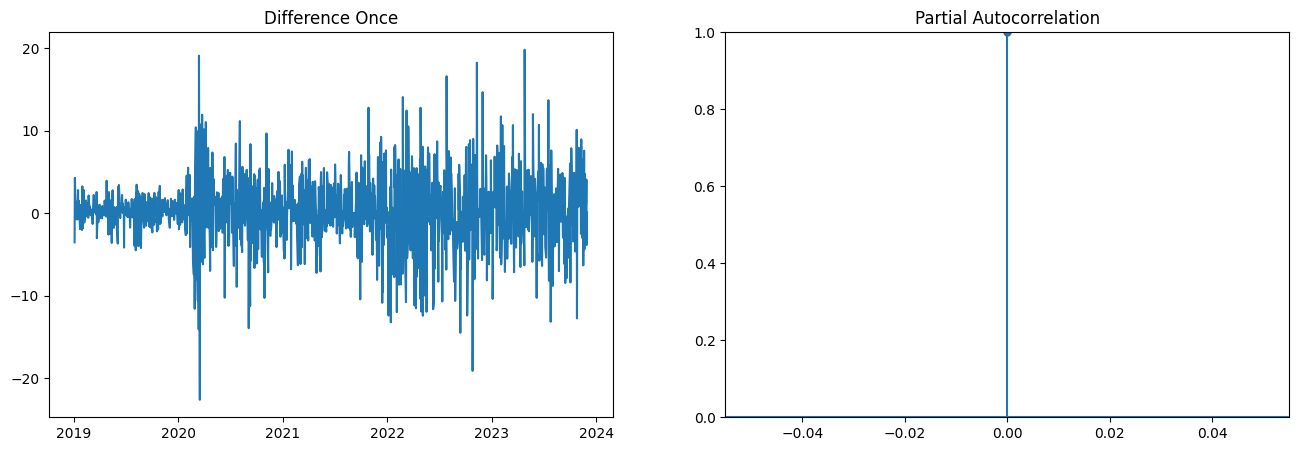

In [161]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(df['Close'].diff())
ax[0].set_title('Difference Once')
plot_pacf(df['Close'].diff(), ax=ax[1])
ax[1].set_ylim(0,1)
plt.show()

##### A significant peak at lag 0 in the PACF suggests that an autoregressive term at lag 0 might be appropriate. Therefore, we could try setting p=1.

### q

#### p is the order of Moving Avergae (MA) term. It refers to the number of lagged forecast errors that should go into ARIMA model.
#### We can find the required number of AR terms by looking at Autocorrelation Plot.

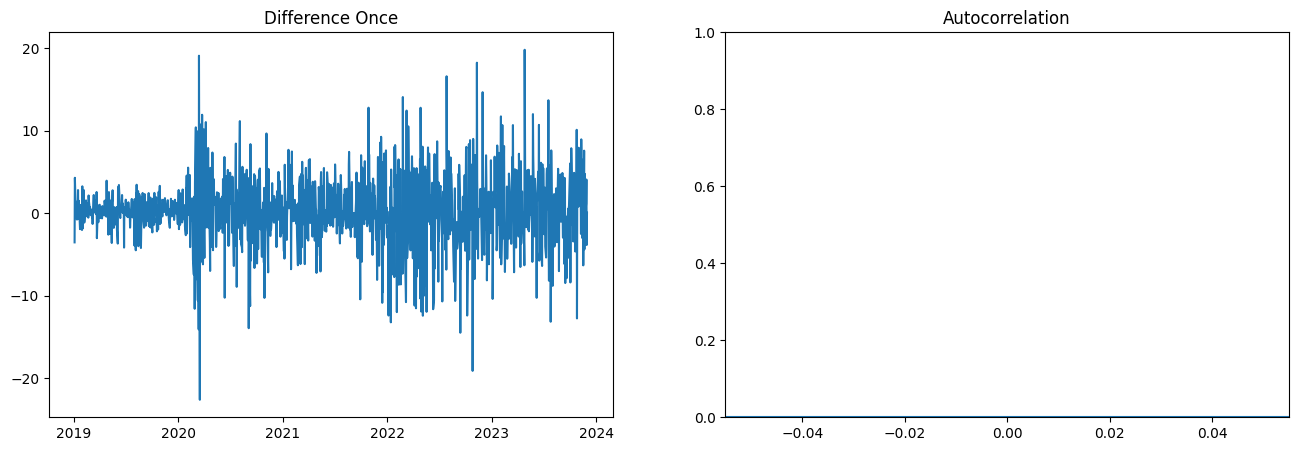

In [162]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(df['Close'].diff())
ax[0].set_title('Difference Once')
plot_acf(df['Close'].diff(), ax=ax[1])
ax[1].set_ylim(0,1)
plt.show()

##### ACF plot does not show significant peaks at any lags, it suggests that there may not be a clear moving average effect. Therefore, we might set q=0

#### Ignoring the parameters discussed above, let's use packages to do Auto-ARIMA

In [163]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7127.597, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7135.051, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7123.918, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7123.139, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7136.511, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7123.911, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7124.333, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7125.851, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7125.538, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.117 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1238
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3558.569
Date:                Sat, 30 Dec 2023   AIC      

#### Splitting the data into Train and Test

In [164]:
train = df.iloc[0:-30]
test = df.iloc[-30:]

#### Fitting the Model

In [165]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(0,1,1))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1208
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3468.851
Date:                Sat, 30 Dec 2023   AIC                           6941.701
Time:                        17:30:37   BIC                           6951.893
Sample:                             0   HQIC                          6945.539
                               - 1208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0979      0.021     -4.632      0.000      -0.139      -0.056
sigma2        18.3568      0.529     34.694      0.000      17.320      19.394
Ljung-Box (L1) (Q):                   0.00   Jarque-

#### Make Predictions on Test set

In [166]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
pred.index = df.index[start:end+1]

In [167]:
pred

Date
2023-10-19    329.633076
2023-10-20    329.633076
2023-10-23    329.633076
2023-10-24    329.633076
2023-10-25    329.633076
2023-10-26    329.633076
2023-10-27    329.633076
2023-10-30    329.633076
2023-10-31    329.633076
2023-11-01    329.633076
2023-11-02    329.633076
2023-11-03    329.633076
2023-11-06    329.633076
2023-11-07    329.633076
2023-11-08    329.633076
2023-11-09    329.633076
2023-11-10    329.633076
2023-11-13    329.633076
2023-11-14    329.633076
2023-11-15    329.633076
2023-11-16    329.633076
2023-11-17    329.633076
2023-11-20    329.633076
2023-11-21    329.633076
2023-11-22    329.633076
2023-11-24    329.633076
2023-11-27    329.633076
2023-11-28    329.633076
2023-11-29    329.633076
2023-11-30    329.633076
Name: predicted_mean, dtype: float64

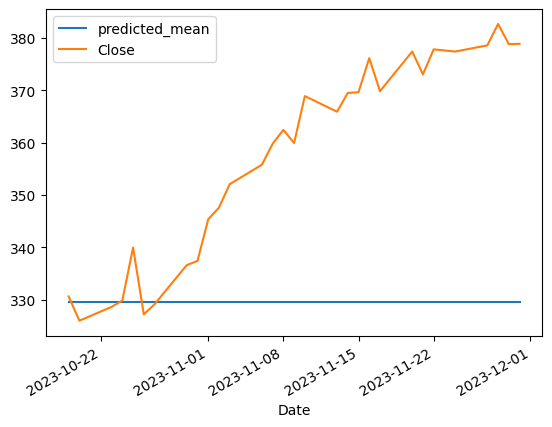

In [168]:
pred.plot(legend=True)
test['Close'].plot(legend=True)
plt.show()

### RMSE

In [169]:
rmse = mean_squared_error(test['Close'], pred, squared=False)
print(rmse)

33.4620650937835
